## 파이썬으로 음성데이터 조련하기

1. y

Mel-Spectrogram을 뽑기 위해서는 librosa.load 로 음성 데이터를 load하여 얻은 y를 넣으면 된다. 이렇게 나머지를 지정하지 않고 추출하였을 경우 default 값으로 추출이된다.

2. sr

y, sr = librosa.load(음성데이터) 를 하게 될 경우, 음성의 sr을 얻을 수 있다. 단 여기에서 중요한 것은, sr을 따로 설정해주지 않으면 librosa는 default인 22050을 주게 된다. 나는 이러한 이유로 soundfile을 사용하여 처음 보는 음성 데이터에 대하여 sr을 체크한 뒤, 그대로 아래처럼 설정해서 sr을 얻는 방법을 사용한다.

y, sr = librosa.load(wav_file, sr=16000)
3. S

S는 librosa.stft(y)를 하면 얻을 수 있다. 즉 Short-Time Fourier Transform을 하여 얻어진 magnitude 와 phase의 값인 것이다. 그렇지만 S는 사용하지 않고 음성 데이터인 y만 넣어도 되므로 pass하겠다.

 

4. n_fft

우리가 보유한 음성 데이터는 현재 time-magnitude domain이다. 이걸 왜 frequency로 바꾸냐면, 주파수 관점에서 바라보았을 때 얻을 수 있는 정보가 많기 때문이다.

음성은 연속적인 신호이다. 그러므로 연속적인 신호를 우리는 frequency로 바꿔야 한다.

 

n_fft는 이 때 사용되는데, 음성의 길이를 얼마만큼으로 자를 것인가? 라고 이해하면 될 것 같다. 이를 window라고 부른다.

사람의 목소리는 대부분 16kHz안에 포함이 된다. 만약 n_fft를 512라고 가정해보겠다. 이렇게 될 경우 1개의 n_fft는 16000/512 = 약 31.25가 된다. 이것이 자연수로 떨어지기 위해 올림을 해주어 32로 설정해준다. 총 음성 데이터의 길이가 500이라고 가정하면, 32만큼 잘라서 1칸을 그리겠다는 것으로 이해하면 된다. 

보유한 음성 데이터의 Sampling Rate가 16000이고, 우리는 n_fft를 512개만 사용할 것이라면, 아래의 공식을 이용하여 구할 수 있다.

 

input_nfft = int(round(sr*frame_length))
frame_length = input_nfft/sr
2번 째 줄을 보면 되겠다.

 

frame_length = 512/16000 = 0.032 => 32ms가 나온다.

 

즉 1개의 window의 크기를 32ms로 잡으면 되고, 이것을 window_length 라고도 부른다.

 

5. hop_length

hop_length는 음성의 magnitude를 얼만큼 겹친 상태로 잘라서 칸으로 보여줄 것인가? 라고 생각하면 편할 것 같다. 즉 window_length - frame_stride 만큼 겹쳐서 1칸을 뽑겠다는 뜻이다. 

 

예를 들어 우리가 보유한 데이터가 7초이고, window_length를 0.025초, frame_stride를 0.010초(10ms)단위로 뽑는다고 가정하면, 1칸은 0.015초(15ms)가 겹치도록 하여 총 700칸을 얻을 수 있다.

 

6. 7은 넘어가도록 하겠다.

 

 

자 그럼 이제 실제로 코드를 돌려서 결과를 얻어 볼 것이다.

 

나는 window length 를 0.025로 두고, stride는 0.010로 진행하여 0.01초마다 frequency를 뽑을 것이다.

 

frame_length = 0.025
frame_stride = 0.010

def Mel_S(wav_file):
    # mel-spectrogram
    y, sr = librosa.load(wav_file, sr=16000)

    # wav_length = len(y)/sr
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))

    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(S)))
 

아래처럼 함수를 선언하였다. 여기에서 중요한 것은, n_mels이다. 만약 16kHz를 Mel_S로 뽑는다면 약 8kHz에 해당하는 주파수를 얻을 수 있다. 이때, 8kHz를 n_mels 크기 만큼으로 나눠준다. 즉 1개의 n_mels의 height는 0.4kHz를 포함하고 있다. 

 

음성 데이터의 길이와 얻은 Mel_Spectrogram의 크기를 출력해보면 다음과 같다.


 

총 길이는 3.35초이고, 0.01 단위에서 올림을하여 3.36이 된다. 그리고 0.01에 1칸이므로 336칸을 얻는다.

 

이렇게 Mel_Spectrogram을 얻었고, 이것을 그려보도록 하겠다. 아래의 코드를 복사하면 된다.


    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=sr, hop_length=input_stride, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.savefig('Mel-Spectrogram example.png')
    plt.show()


In [2]:
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

%matplotlib inline

audio_path_1 = 'happy (1).wav'
audio_path_2 = 'four (1).wav'
audio_path_3 = 'zero (1).wav'
y1, sr = librosa.load(audio_path_1)
y2, sr = librosa.load(audio_path_2)
y3, sr = librosa.load(audio_path_3)
ori_sent1 = 'happy'
ori_sent2 = 'four'
ori_sent3 = 'zero'

### y
Mel-Spectrogram을 뽑기 위해서는 librosa.load로 음성 데이터를 load하여 얻은 y를 넣으면 된다. 이렇게 나머지를 지정하지 않고 추출하였을 경우 default 값으로 추출이된다.

### sr
y, sr = librosa.load(음성데이터) 를 하게 될 경우, 음성의 sr을 얻을 수 있다. 단 여기에서 중요한 것은, sr을 따로 설정해주지 않으면 librosa는 default인 22050을 주게 된다. 나는 이러한 이유로 soundfile을 사용하여 처음 보는 음성 데이터에 대하여 sr을 체크한 뒤, 그대로 아래처럼 설정해서 sr을 얻는 방법을 사용한다.


### n__fft
우리가 보유한 음성 데이터는 현재 time-magnitude domain이다. 이걸 왜 frequency로 바꾸냐면, 주파수 관점에서 바라보았을 때 얻을 수 있는 정보가 많기 때문이다.

음성은 연속적인 신호이다. 그러므로 연속적인 신호를 우리는 frequency로 바꿔야 한다.

n_fft는 이 때 사용되는데, 음성의 길이를 얼마만큼으로 자를 것인가? 라고 이해하면 될 것 같다. 이를 window라고 부른다.

사람의 목소리는 대부분 16kHz안에 포함이 된다. 만약 n_fft를 512라고 가정해보겠다. 이렇게 될 경우 1개의 n_fft는 16000/512 = 약 31.25가 된다. 이것이 자연수로 떨어지기 위해 올림을 해주어 32로 설정해준다. 총 음성 데이터의 길이가 500이라고 가정하면, 32만큼 잘라서 1칸을 그리겠다는 것으로 이해하면 된다. 

보유한 음성 데이터의 Sampling Rate가 16000이고, 우리는 n_fft를 512개만 사용할 것이라면, 아래의 공식을 이용하여 구할 수 있다.

In [ ]:
input_nfft = int(round(sr*frame_length))
frame_length = input_nfft/sr

### hop_length
hop_length는 음성의 magnitude를 얼만큼 겹친 상태로 잘라서 칸으로 보여줄 것인가? 라고 생각하면 편할 것 같다. 즉 window_length - frame_stride 만큼 겹쳐서 1칸을 뽑겠다는 뜻이다. 

 

예를 들어 우리가 보유한 데이터가 7초이고, window_length를 0.025초, frame_stride를 0.010초(10ms)단위로 뽑는다고 가정하면, 1칸은 0.015초(15ms)가 겹치도록 하여 총 700칸을 얻을 수 있다.



In [3]:
IPython.display.Audio(data = y1, rate = sr)

In [4]:
IPython.display.Audio(data = y2, rate = sr)

In [5]:
IPython.display.Audio(data = y3, rate = sr)

In [6]:
# happy
D = librosa.amplitude_to_db(librosa.stft(y1[:1024]), ref = np.max)
plt.plot(D.flatten())
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [7]:
# four
D = librosa.amplitude_to_db(librosa.stft(y2[:1024]), ref = np.max)
plt.plot(D.flatten())
plt.show()

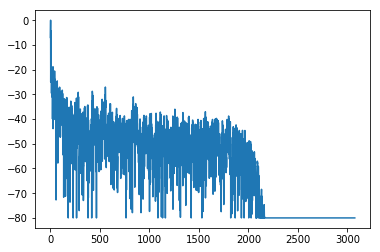

In [8]:
# zero
D = librosa.amplitude_to_db(librosa.stft(y3[:1024]), ref = np.max)
plt.plot(D.flatten())
plt.show()

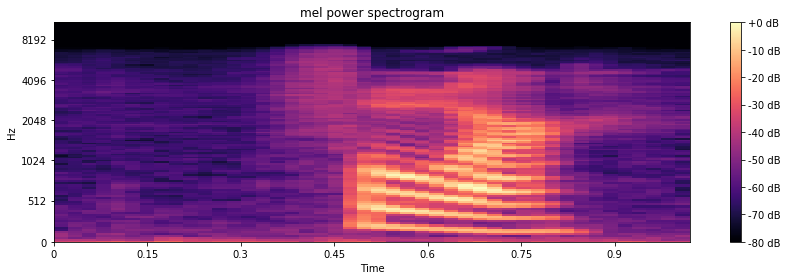

In [9]:
S = librosa.feature.melspectrogram(y2, sr = sr, n_mels = 128)

log_S = librosa.power_to_db(S, np.max)
plt.figure(figsize = (12,4))
librosa.display.specshow(log_S, sr = sr, x_axis = 'time', y_axis = 'mel')
plt.title('mel power spectrogram')
plt.colorbar(format = '%+02.0f dB')
plt.tight_layout()
plt.show()


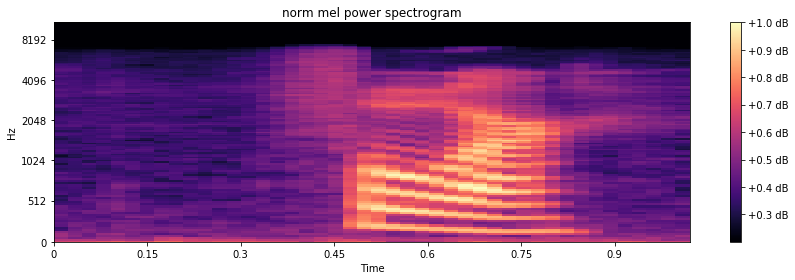

In [10]:
min_level_db = -100

def _normalize(S):
    return np.clip((S - min_level_db) / -min_level_db, 0, 1)

norm_S = _normalize(log_S)

plt.figure(figsize = (12, 4))
librosa.display.specshow(norm_S, sr = sr, x_axis = 'time', y_axis = 'mel')
plt.title('norm mel power spectrogram')
plt.colorbar(format = '%+0.1f dB')
plt.tight_layout()
plt.show()

In [11]:
norm_S

array([[0.6591421 , 0.6641228 , 0.68201095, ..., 0.63960916, 0.64921844,
        0.64222354],
       [0.5946754 , 0.5989925 , 0.5911033 , ..., 0.5734471 , 0.5138106 ,
        0.531104  ],
       [0.5246209 , 0.4733487 , 0.49097964, ..., 0.5729302 , 0.531499  ,
        0.50833243],
       ...,
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ],
       [0.2       , 0.2       , 0.2       , ..., 0.2       , 0.2       ,
        0.2       ]], dtype=float32)

In [13]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref = np.max),
        y_axis = 'mel', sr = sr, hop_length = input_stride, x_axis = 'time')
plt.colorbar(format = '%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png')
plt.show()

NameError: name 'input_stride' is not defined

<Figure size 720x288 with 0 Axes>

Wav length: 1.0, Mel_S shape:(40, 101)


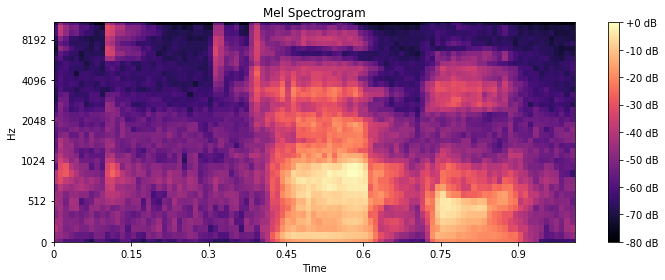

In [17]:
frame_length = 0.025
frame_stride = 0.010

def Mel_S(wav_file):
    # mel-spectrogram
    y, sr = librosa.load(wav_file, sr = 16000)

    # wav_length = len(y) / sr
    input_nfft = int(round(sr * frame_length))
    input_stride = int(round(sr * frame_stride))
    S = librosa.feature.melspectrogram(y = y, n_mels = 40, n_fft = input_nfft, hop_length = input_stride)
   
    print("Wav length: {}, Mel_S shape:{}".format(len(y) / sr, np.shape(S)))
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S, ref = np.max),
    y_axis = 'mel', sr = sr, hop_length = input_stride, x_axis = 'time')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig('Mel-Spectrogram example.png')
    plt.show()
    
    return S

test_data = 'happy (1).wav'
mel_spec = Mel_S(test_data)

In [18]:
mel_spec

array([[1.4040233e-05, 8.1778126e-06, 1.7045038e-06, ..., 7.2136061e-07,
        6.5915094e-07, 9.7858174e-07],
       [3.6256046e-05, 3.3779441e-05, 1.8935494e-05, ..., 4.3478467e-06,
        2.0515152e-05, 3.4908840e-05],
       [1.4292079e-04, 5.3080454e-05, 1.1661796e-05, ..., 8.8358920e-06,
        5.9589867e-05, 8.1920014e-05],
       ...,
       [1.4773032e-06, 2.1705368e-04, 2.8542208e-05, ..., 1.3820016e-07,
        1.3179431e-07, 1.8518296e-07],
       [1.5061541e-06, 3.0123105e-04, 3.9700284e-05, ..., 1.4677943e-07,
        1.7230883e-07, 1.1150481e-07],
       [2.6860525e-07, 3.5251072e-05, 5.0649169e-06, ..., 2.6093423e-08,
        2.4448443e-08, 1.1505659e-08]], dtype=float32)